

# 🌐 **Google Drive Connection / libraries import**

In [14]:
# Set seed for reproducibility
SEED = 42
!pip install lion-pytorch
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import PIL.Image
from tqdm.notebook import tqdm
import copy
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from lion_pytorch import Lion
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from lion_pytorch import Lion
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms.functional as TF
import torch



# Configure plot settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Google Drive Connection
from google.colab import drive
drive.mount('/gdrive')

# Definisci qui il percorso base
base_dir = "/gdrive/MyDrive/ANNDL/Challenge 2"

try:
    os.chdir(base_dir)
    print(f"Directory corrente: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error")

PyTorch version: 2.9.0+cu126
Device: cuda
Mounted at /gdrive
Directory corrente: /gdrive/MyDrive/ANNDL/Challenge 2


# ⚙️ **Data Loading**


In [15]:

dataset_root = "an2dl2526c2"

train_img_dir = os.path.join(dataset_root, "train_data")
test_img_dir = os.path.join(dataset_root, "test_data")
labels_path = os.path.join(dataset_root, "train_labels_cleaned2.csv") #cleaned labels without shrek images

# Load labels dataframe
if os.path.exists(labels_path):
    train_df = pd.read_csv(labels_path)
    print(f"Labels loaded. Shape: {train_df.shape}")
    print(f"Training images path: {train_img_dir}")

Labels loaded. Shape: (571, 2)
Training images path: an2dl2526c2/train_data


# 🔄 **Data Preprocessing**

In [16]:
# Parameters Preprocessing
IMG_SIZE = 384
BATCH_SIZE = 16
NUM_WORKERS = 2

print(f"Device: {device}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
display(train_df.head())

Device: cuda
Image Size: 384x384
Batch Size: 16


sample_index            label
0  img_0000.png  Triple negative
1  img_0002.png        Luminal B
2  img_0003.png        Luminal B
3  img_0004.png        Luminal B
4  img_0006.png        Luminal A

In [17]:
# Encode textual labels into integers
label_map = {
    'Luminal A': 0,
    'Luminal B': 1,
    'HER2(+)': 2,
    'Triple negative': 3
}

# Create a new column 'label_idx'
train_df['label_idx'] = train_df['label'].map(label_map)

# Verify mapping
print("Label mapping:", label_map)
display(train_df[['sample_index', 'label', 'label_idx']].head())

Label mapping: {'Luminal A': 0, 'Luminal B': 1, 'HER2(+)': 2, 'Triple negative': 3}


sample_index            label  label_idx
0  img_0000.png  Triple negative          3
1  img_0002.png        Luminal B          1
2  img_0003.png        Luminal B          1
3  img_0004.png        Luminal B          1
4  img_0006.png        Luminal A          0

In [18]:
# Split
X_train_df, X_val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label_idx'],
    random_state=SEED
)

X_train_df = X_train_df.reset_index(drop=True)
X_val_df = X_val_df.reset_index(drop=True)

print(f"Training samples: {len(X_train_df)}")
print(f"Validation samples: {len(X_val_df)}")

Training samples: 456
Validation samples: 115


In [19]:
# Dataset
# normalization parameter
IMG_SIZE = 384
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

class DualStreamDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, is_train=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.is_train = is_train

        # Trasformations
        self.resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=MEAN, std=STD)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = str(row['sample_index'])
        if not img_name.endswith('.png'): img_name += '.png'

        # path
        img_path = os.path.join(self.root_dir, img_name)
        mask_name = img_name.replace("img_", "mask_")
        mask_path = os.path.join(self.root_dir, mask_name)


        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = PIL.Image.fromarray(image)
        except:
            image = PIL.Image.new('RGB', (IMG_SIZE, IMG_SIZE))


        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = PIL.Image.fromarray(mask)
        else:
            if self.is_train:
                mask = PIL.Image.new('L', image.size, 0)
            else:

                gray = image.convert('L')
                mask = gray.point(lambda p: 255 if p < 210 else 0)

        # Resize
        image = self.resize(image)
        mask = self.resize(mask)

        # Augmentation
        if self.is_train:

            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)


            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)


            k = random.randint(0, 3)
            if k > 0:
                image = TF.rotate(image, k * 90)
                mask = TF.rotate(mask, k * 90)

            if random.random() < 0.8:
                jit = transforms.ColorJitter(
                    brightness=0.3,
                    contrast=0.3,
                    saturation=0.4,
                    hue=0.15
                )
                image = jit(image)

        image = self.to_tensor(image)
        image = self.normalize(image)

        mask = self.to_tensor(mask)

        label = row['label_idx'] if 'label_idx' in row else -1

        return image, mask, label

In [20]:
# Initialize Datasets & Loaders

train_dataset = DualStreamDataset(X_train_df, train_img_dir, is_train=True)
val_dataset = DualStreamDataset(X_val_df, train_img_dir, is_train=False)

# Initialize DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"DataLoaders initialized.\n   Train samples: {len(train_dataset)}\n   Val samples: {len(val_dataset)}\n   Batch Size: {BATCH_SIZE}")

DataLoaders initialized.
   Train samples: 456
   Val samples: 115
   Batch Size: 16


Batch Shapes -> Img: torch.Size([4, 3, 384, 384]), Mask: torch.Size([4, 1, 384, 384]), Label: torch.Size([4])


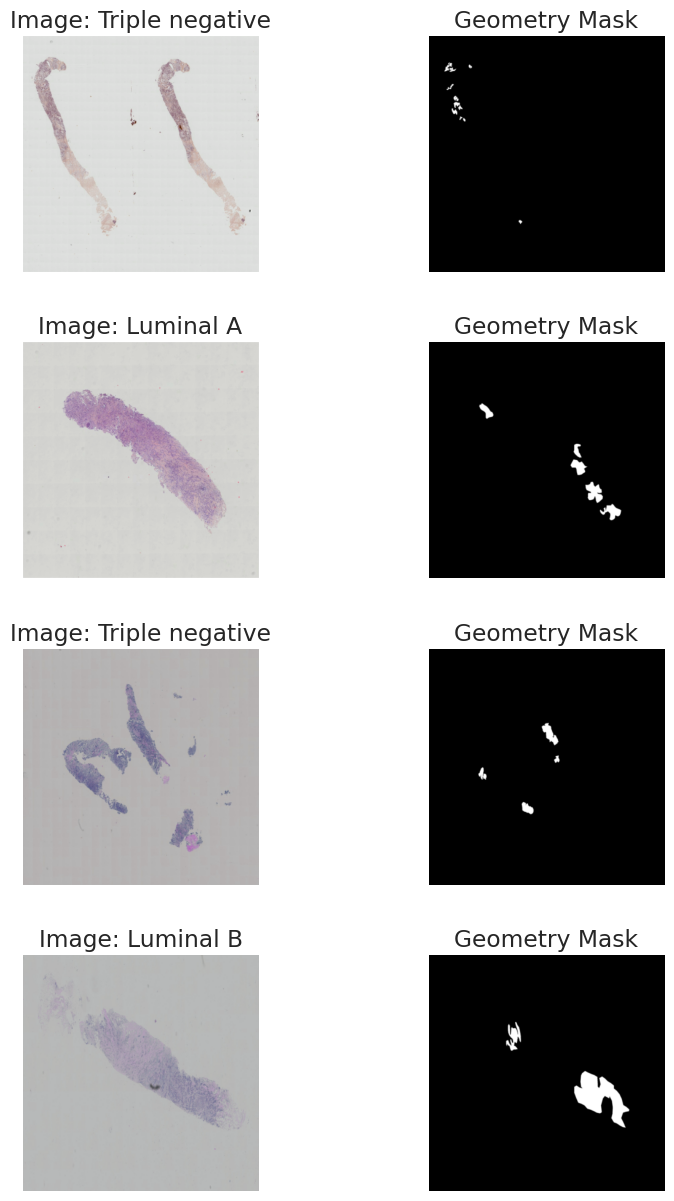

In [21]:
# visualize test batch
def denormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

temp_ds = DualStreamDataset(train_df.iloc[:32], train_img_dir, is_train=True)
temp_loader = DataLoader(temp_ds, batch_size=4, shuffle=True)
images, masks, labels = next(iter(temp_loader))

print(f"Batch Shapes -> Img: {images.shape}, Mask: {masks.shape}, Label: {labels.shape}")

# Plot
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i in range(4):
    ax_img = axes[i, 0]
    img_disp = denormalize(images[i]).permute(1, 2, 0)
    ax_img.imshow(img_disp)
    label_name = list(label_map.keys())[list(label_map.values()).index(labels[i].item())]
    ax_img.set_title(f"Image: {label_name}")
    ax_img.axis("off")

    # Mask
    ax_mask = axes[i, 1]
    mask_disp = masks[i].squeeze().cpu().numpy()
    ax_mask.imshow(mask_disp, cmap="gray")
    ax_mask.set_title("Geometry Mask")
    ax_mask.axis("off")

plt.show()

# 🛠️ **Model Building**

In [22]:
class DualStreamNetwork(nn.Module):
    def __init__(self, num_classes=4):
        super(DualStreamNetwork, self).__init__()

        # ConvNeXt Tiny
        self.rgb_backbone = models.convnext_tiny(weights='IMAGENET1K_V1')
        self.rgb_dim = self.rgb_backbone.classifier[2].in_features
        self.rgb_backbone.classifier = nn.Sequential(
            self.rgb_backbone.classifier[0],
            self.rgb_backbone.classifier[1]
        )

        # ResNet18 for mask
        raw_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.mask_backbone = raw_resnet
        original_weights = self.mask_backbone.conv1.weight.data

        self.mask_backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mask_backbone.conv1.weight.data = original_weights.sum(dim=1, keepdim=True)

        self.mask_dim = self.mask_backbone.fc.in_features
        self.mask_backbone.fc = nn.Identity()

        # merge
        fusion_dim = self.rgb_dim + self.mask_dim

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(fusion_dim),
            nn.Dropout(p=0.6),
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_rgb, x_mask):
        rgb_feat = self.rgb_backbone(x_rgb)
        mask_feat = self.mask_backbone(x_mask)
        combined = torch.cat((rgb_feat, mask_feat), dim=1)
        return self.classifier(combined)

def get_model(num_classes=4):
    return DualStreamNetwork(num_classes)

# 🧮 **Network and Training Hyperparameters**

In [23]:
# weights
class_counts = train_df['label_idx'].value_counts().sort_index().values
n_classes = len(class_counts)
total_samples = sum(class_counts)
base_weights = (total_samples / (n_classes * class_counts)) ** 0.7
base_weights[1] *= 1.3
base_weights[2] *= 1.5

# Normalization
base_weights = base_weights / base_weights.mean()

print(f"Counts: {class_counts}")
print(f"Weights: {base_weights}")

class_weights = torch.tensor(base_weights, dtype=torch.float).to(device)

EPOCHS = 20
LR_WARMUP = 1e-4
LR_FINE_TUNE = 3.5e-5
WEIGHT_DECAY = 0.1
PATIENCE = 5
WARMUP_EPOCHS = 3
T_0_CYCLE = 13
ETA_MIN = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.17)

print(f"Setup: ConvNeXt Small, BS={BATCH_SIZE}")

Counts: [155 201 148  67]
Weights: [0.73639368 0.79808354 1.14090714 1.32461564]
Setup: ConvNeXt Small, BS=16


# 🧠 **Model Training**

In [24]:
# Training Function

#cut mix
def cutmix_dual(img, mask, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = img.size(0)
    index = torch.randperm(batch_size).to(img.device)

    # Coordinate Bounding Box
    W, H = img.size(2), img.size(3)
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    #  CutMix to RGB
    img[:, :, bbx1:bbx2, bby1:bby2] = img[index, :, bbx1:bbx2, bby1:bby2]
    #  CutMix to mask
    mask[:, :, bbx1:bbx2, bby1:bby2] = mask[index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = y, y[index]
    return img, mask, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, loader, criterion, optimizer, device, use_cutmix=False):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    loop = tqdm(loader, leave=False)

    for images, masks, labels in loop:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_cutmix and np.random.rand() < 0.5:

            images, masks, targets_a, targets_b, lam = cutmix_dual(images, masks, labels, alpha=1.0)
            outputs = model(images, masks)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
        else:
            outputs = model(images, masks)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        all_preds.extend(preds.cpu().numpy())
        loop.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, masks, labels in loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, masks)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = running_loss / len(loader.dataset)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    return val_loss, val_f1

In [25]:
# TRAINING
N_FOLDS = 5
TARGET_FOLDS = [0, 1, 2, 3, 4]
history_log = {'train_loss': [], 'val_f1': []}

# Setup Splitter
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
X_mock = np.zeros(len(train_df))
y = train_df['label_idx'].values

fold_best_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_mock, y)):
    if fold not in TARGET_FOLDS:
        continue

    print(f"\n{'='*15} TRAINING FOLD {fold+1}/{N_FOLDS} {'='*15}")

    fold_train = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val = train_df.iloc[val_idx].reset_index(drop=True)

    # Dataset
    train_ds = DualStreamDataset(fold_train, train_img_dir, is_train=True)
    val_ds = DualStreamDataset(fold_val, train_img_dir, is_train=False)

    train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = get_model(4).to(device)

    # Warmup
    print("Warmup...")
    for param in model.rgb_backbone.parameters(): param.requires_grad = False
    for param in model.mask_backbone.parameters(): param.requires_grad = False

    optimizer = Lion(model.classifier.parameters(), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)
    for _ in range(WARMUP_EPOCHS):
        train_one_epoch(model, train_ld, criterion, optimizer, device, use_cutmix=False)

    # Full Tuning
    print("Tuning...")
    for param in model.parameters(): param.requires_grad = True

    optimizer = Lion(model.parameters(), lr=LR_FINE_TUNE, weight_decay=WEIGHT_DECAY)

    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=T_0_CYCLE, T_mult=1, eta_min=ETA_MIN
    )

    best_f1 = 0.0
    early_stop_counter = 0
    current_fold_loss = []
    current_fold_f1 = []

    for epoch in range(EPOCHS):
        t_loss, t_f1 = train_one_epoch(model, train_ld, criterion, optimizer, device, use_cutmix=True)
        v_loss, v_f1 = validate(model, val_ld, criterion, device)
        scheduler.step()

        current_fold_loss.append(t_loss)
        current_fold_f1.append(v_f1)

        if v_f1 > best_f1:
            best_f1 = v_f1
            early_stop_counter = 0
            save_path = f'dual_model_fold{fold}.pth'
            torch.save(model.state_dict(), save_path)
            print(f"Ep {epoch+1}: T_Loss {t_loss:.3f} | V_F1 {v_f1:.4f} Saved")
        else:
            early_stop_counter += 1
            print(f"Ep {epoch+1}: T_Loss {t_loss:.3f} | V_F1 {v_f1:.4f}")

        if early_stop_counter >= PATIENCE:
            print("Early Stopping")
            break

    fold_best_scores.append(best_f1)
    if not history_log['train_loss']:
        history_log['train_loss'] = current_fold_loss
        history_log['val_f1'] = current_fold_f1
    print(f" Fold {fold+1} Completed. Best F1: {best_f1:.4f}")

print(f"\n CV AVERAGE: {np.mean(fold_best_scores):.4f}")


=============== TRAINING FOLD 1/5 ===============
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:02<00:00, 54.0MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 76.7MB/s]


Warmup...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Tuning...


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 1: T_Loss 1.413 | V_F1 0.2710 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 2: T_Loss 1.401 | V_F1 0.2847 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 3: T_Loss 1.393 | V_F1 0.2039


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 4: T_Loss 1.379 | V_F1 0.2292


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 5: T_Loss 1.419 | V_F1 0.2219


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 6: T_Loss 1.373 | V_F1 0.2943 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 7: T_Loss 1.352 | V_F1 0.2981 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 8: T_Loss 1.362 | V_F1 0.2252


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 9: T_Loss 1.356 | V_F1 0.2428


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 10: T_Loss 1.344 | V_F1 0.2314


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 11: T_Loss 1.335 | V_F1 0.2314


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 12: T_Loss 1.343 | V_F1 0.2551
Early Stopping
 Fold 1 Completed. Best F1: 0.2981

=============== TRAINING FOLD 2/5 ===============
Warmup...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Tuning...


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 1: T_Loss 1.390 | V_F1 0.1939 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 2: T_Loss 1.427 | V_F1 0.2239 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 3: T_Loss 1.410 | V_F1 0.2171


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 4: T_Loss 1.412 | V_F1 0.1360


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 5: T_Loss 1.384 | V_F1 0.1430


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 6: T_Loss 1.389 | V_F1 0.1995


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 7: T_Loss 1.408 | V_F1 0.2725 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 8: T_Loss 1.414 | V_F1 0.1314


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 9: T_Loss 1.366 | V_F1 0.1587


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 10: T_Loss 1.398 | V_F1 0.2381


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 11: T_Loss 1.400 | V_F1 0.2483


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 12: T_Loss 1.400 | V_F1 0.2461
Early Stopping
 Fold 2 Completed. Best F1: 0.2725

=============== TRAINING FOLD 3/5 ===============
Warmup...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Tuning...


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 1: T_Loss 1.409 | V_F1 0.2612 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 2: T_Loss 1.415 | V_F1 0.2150


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 3: T_Loss 1.364 | V_F1 0.2446


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 4: T_Loss 1.394 | V_F1 0.2556


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 5: T_Loss 1.397 | V_F1 0.2543


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 6: T_Loss 1.359 | V_F1 0.2506
Early Stopping
 Fold 3 Completed. Best F1: 0.2612

=============== TRAINING FOLD 4/5 ===============
Warmup...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Tuning...


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 1: T_Loss 1.404 | V_F1 0.2927 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 2: T_Loss 1.388 | V_F1 0.1687


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 3: T_Loss 1.367 | V_F1 0.2988 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 4: T_Loss 1.412 | V_F1 0.2753


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 5: T_Loss 1.408 | V_F1 0.2329


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 6: T_Loss 1.407 | V_F1 0.1821


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 7: T_Loss 1.418 | V_F1 0.2097


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 8: T_Loss 1.402 | V_F1 0.1971
Early Stopping
 Fold 4 Completed. Best F1: 0.2988

=============== TRAINING FOLD 5/5 ===============
Warmup...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Tuning...


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 1: T_Loss 1.362 | V_F1 0.2498 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 2: T_Loss 1.351 | V_F1 0.2659 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 3: T_Loss 1.379 | V_F1 0.2581


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 4: T_Loss 1.381 | V_F1 0.2760 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 5: T_Loss 1.399 | V_F1 0.3260 Saved


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 6: T_Loss 1.396 | V_F1 0.2789


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 7: T_Loss 1.402 | V_F1 0.2767


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 8: T_Loss 1.323 | V_F1 0.2539


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 9: T_Loss 1.323 | V_F1 0.2976


  0%|          | 0/28 [00:00<?, ?it/s]

Ep 10: T_Loss 1.311 | V_F1 0.2758
Early Stopping
 Fold 5 Completed. Best F1: 0.3260

 CV AVERAGE: 0.2913


# running

In [26]:
# Test Dataset

class DualStreamTestDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform

        self.files = [f for f in os.listdir(dir_path)
                      if f.lower().endswith('.png') and f.startswith('img_')]
        self.files.sort()

        self.resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
        self.normalize = transforms.Normalize(mean=MEAN, std=STD)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        img_fname = self.files[idx]
        img_path = os.path.join(self.dir_path, img_fname)

        mask_fname = img_fname.replace("img_", "mask_")
        mask_path = os.path.join(self.dir_path, mask_fname)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = PIL.Image.fromarray(image)


        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = PIL.Image.fromarray(mask)

        # Resize and Transform
        image = self.resize(image)
        mask = self.resize(mask)

        image = self.to_tensor(image)
        image = self.normalize(image)


        mask = self.to_tensor(mask)

        return image, mask, img_fname

test_dataset = DualStreamTestDataset(test_img_dir)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
print(f"Test Loader pronto: {len(test_dataset)}")

Test Loader pronto: 477


In [30]:
# Weighted Ensemble Inference
FOLD_WEIGHTS = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0
}

models_map = {}
total_weight = 0

for fold_idx, weight in FOLD_WEIGHTS.items():
    path = f'dual_model_fold{fold_idx}.pth'
    if os.path.exists(path):

      m = get_model(4).to(device)
      m.load_state_dict(torch.load(path))
      m.eval()
      models_map[fold_idx] = {'model': m, 'weight': weight}
      total_weight += weight
      print(f" Fold {fold_idx+1} | weight: {weight}")


def resize_tensor(t, size):
    return F.interpolate(t, size=size, mode='bilinear', align_corners=False)
def resize_mask(t, size):
    return F.interpolate(t, size=size, mode='nearest')

def get_dual_tta_preds_safe(model, img, mask):
    probs = []
    probs.append(torch.softmax(model(img, mask), dim=1))
    # Rotations
    for k in [1, 2, 3]:
        probs.append(torch.softmax(model(torch.rot90(img, k, [2, 3]), torch.rot90(mask, k, [2, 3])), dim=1))
    # Flip
    img_f, mask_f = torch.flip(img, [3]), torch.flip(mask, [3])
    probs.append(torch.softmax(model(img_f, mask_f), dim=1))
    # Flip + Rotations
    for k in [1, 2, 3]:
        probs.append(torch.softmax(model(torch.rot90(img_f, k, [2, 3]), torch.rot90(mask_f, k, [2, 3])), dim=1))
    return torch.stack(probs).mean(dim=0)

predictions = []
file_names = []

if models_map:
    with torch.no_grad():
        for images, masks, fnames in tqdm(test_loader, desc="Ensemble Inference"):
            images = images.to(device)
            masks = masks.to(device)
            batch_probs = torch.zeros((images.size(0), 4)).to(device)

            # Zoom Crop (80%)
            h, w = images.shape[2:]
            ch, cw = int(h*0.8), int(w*0.8)
            sh, sw = int(h*0.1), int(w*0.1)

            zoom_images = images[:, :, sh:sh+ch, sw:sw+cw]
            zoom_masks = masks[:, :, sh:sh+ch, sw:sw+cw]

            zoom_images = resize_tensor(zoom_images, (IMG_SIZE, IMG_SIZE))
            zoom_masks = resize_mask(zoom_masks, (IMG_SIZE, IMG_SIZE))

            for fold_idx, item in models_map.items():
                model = item['model']
                weight = item['weight']


                p1 = get_dual_tta_preds_safe(model, images, masks)

                p2 = get_dual_tta_preds_safe(model, zoom_images, zoom_masks)

                p_combined = (p1 * 0.6 + p2 * 0.4)

                batch_probs += (p_combined * weight)

            batch_probs /= total_weight

            # Argmax Standard
            _, preds = torch.max(batch_probs, 1)
            predictions.extend(preds.cpu().numpy())
            file_names.extend(fnames)

    # Export
    inv_label_map = {v: k for k, v in label_map.items()}
    pred_labels = [inv_label_map[p] for p in predictions]
    sub_df = pd.DataFrame({'sample_index': file_names, 'label': pred_labels})
    sub_df.to_csv('submission.csv', index=False)
    print("Submission Created")


 Fold 1 | weight: 1.0
 Fold 2 | weight: 1.0
 Fold 3 | weight: 1.0
 Fold 4 | weight: 1.0
 Fold 5 | weight: 1.0


Ensemble Inference:   0%|          | 0/30 [00:00<?, ?it/s]

Submission Created


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

                 precision    recall  f1-score   support

      Luminal A       0.40      0.15      0.22       155
      Luminal B       0.37      0.50      0.43       201
        HER2(+)       0.27      0.34      0.30       148
Triple negative       0.26      0.19      0.22        67

       accuracy                           0.33       571
      macro avg       0.32      0.30      0.29       571
   weighted avg       0.34      0.33      0.31       571

 Overall CV: 0.2915


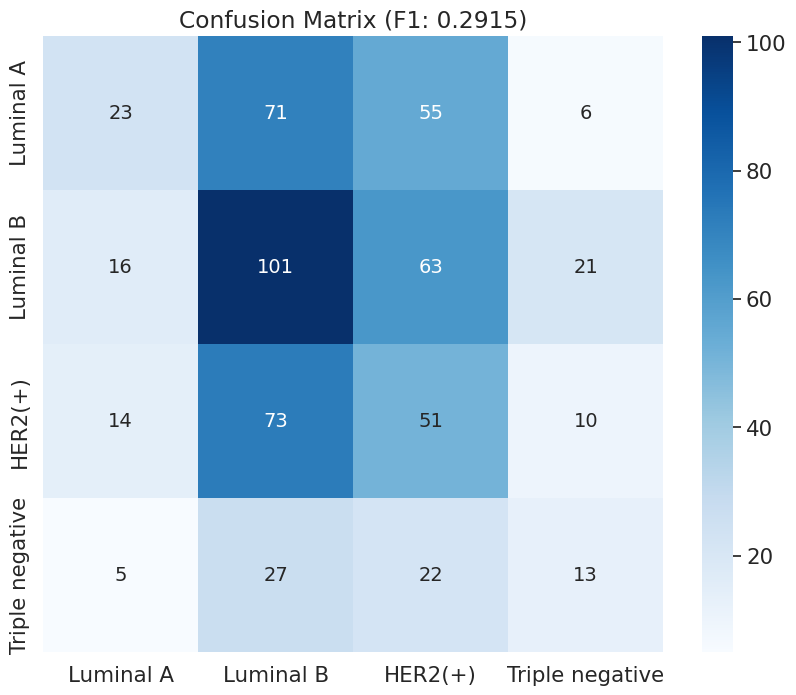

In [31]:
# evaluation
y_true_all = []
y_pred_all = []
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
X_mock = np.zeros(len(train_df))
y = train_df['label_idx'].values


def get_dual_tta_preds(model, img, mask):
    probs = [torch.softmax(model(img, mask), dim=1)]
    for k in [1, 2, 3]:
        probs.append(torch.softmax(model(torch.rot90(img, k, [2, 3]), torch.rot90(mask, k, [2, 3])), dim=1))

    img_flip, mask_flip = torch.flip(img, [3]), torch.flip(mask, [3])
    probs.append(torch.softmax(model(img_flip, mask_flip), dim=1))

    for k in [1, 2, 3]:
        probs.append(torch.softmax(model(torch.rot90(img_flip, k, [2, 3]), torch.rot90(mask_flip, k, [2, 3])), dim=1))

    return torch.stack(probs).mean(dim=0)


for fold, (_, val_idx) in enumerate(skf.split(X_mock, y)):
    model_path = f"dual_model_fold{fold}.pth"
    model = get_model(4).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)
    val_ds = DualStreamDataset(fold_val_df, train_img_dir, is_train=False)
    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for images, masks, labels in tqdm(val_ld, leave=False):
            images, masks = images.to(device), masks.to(device)

            p = get_dual_tta_preds(model, images, masks)
            _, preds = torch.max(p, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.numpy())

    y_true_all.extend(fold_labels)
    y_pred_all.extend(fold_preds)

# Report

target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]
print(classification_report(y_true_all, y_pred_all, target_names=target_names))

f1 = f1_score(y_true_all, y_pred_all, average='macro')
print(f" Overall CV: {f1:.4f}")

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1: {f1:.4f})')
plt.show()

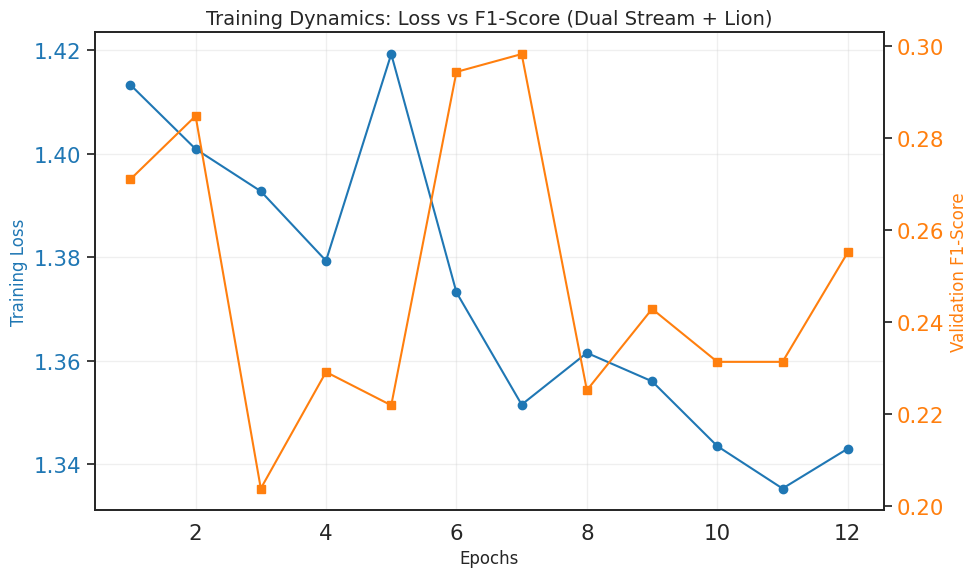

In [32]:
# PLOT
if history_log['train_loss']:
    epochs = range(1, len(history_log['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss
    color = 'tab:blue'
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color, fontsize=12)
    ax1.plot(epochs, history_log['train_loss'], color=color, marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Plot F1
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Validation F1-Score', color=color, fontsize=12)
    ax2.plot(epochs, history_log['val_f1'], color=color, marker='s', label='Val F1')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Dynamics: Loss vs F1-Score (Dual Stream + Lion)', fontsize=14)
    fig.tight_layout()

    plt.savefig('training_curve_report.png', dpi=300)
    plt.show()

